# Detecting Illicit Bitcoin Transactions Using Graph Neural Networks


---
## 2. Setup & Data Loading

In [2]:
import torch
print(f'PyTorch: {torch.__version__}')
print(f'CUDA: {torch.version.cuda}')

!pip install torch-geometric python-louvain -q

PyTorch: 2.10.0+cu128
CUDA: 12.8


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

features = pd.read_csv('elliptic_txs_features.csv', header=None)
edges    = pd.read_csv('elliptic_txs_edgelist.csv')
classes  = pd.read_csv('elliptic_txs_classes.csv')

classes.columns  = ['txId', 'class']
features.columns = ['txId', 'time_step'] + [f'f{i}' for i in range(165)]

df_merged = pd.merge(features, classes, on='txId')
df        = df_merged.copy()   # working copy

print('Dataset shape:', df.shape)
print('\nClass distribution:')
print(df['class'].value_counts())
print('\nEdge list shape:', edges.shape)

Dataset shape: (203769, 168)

Class distribution:
class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64

Edge list shape: (234355, 2)


---
## 4. Exploratory Data Analysis

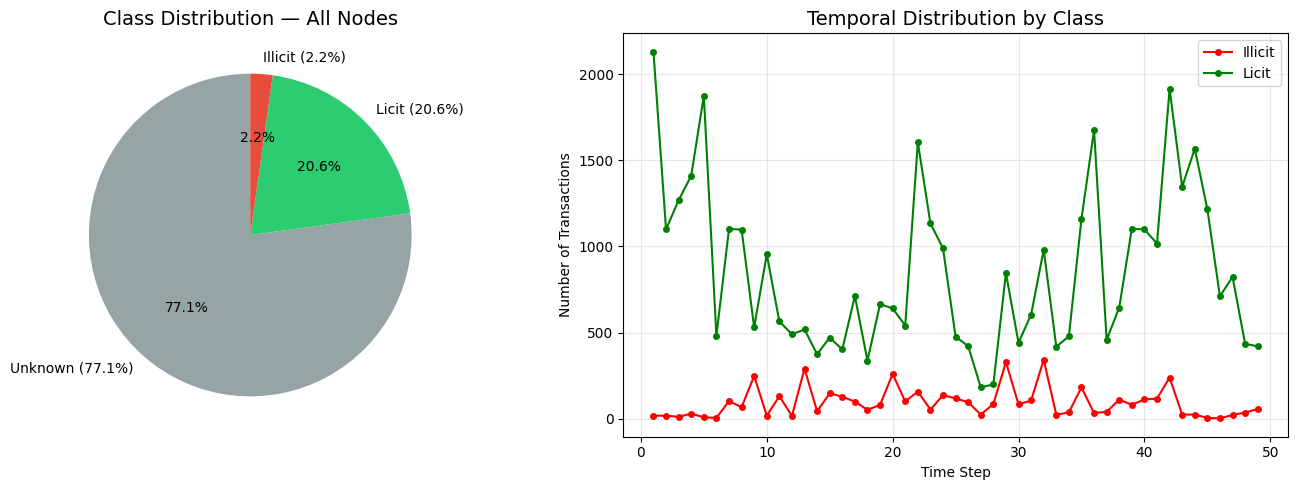

Total labeled nodes : 46,564
Illicit (class 1)   : 4,545  (9.8%)
Licit   (class 2)   : 42,019  (90.2%)


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

counts = df['class'].value_counts()
colors = ['#95a5a6', '#2ecc71', '#e74c3c']
axes[0].pie(counts.values,
            labels=['Unknown (77.1%)', 'Licit (20.6%)', 'Illicit (2.2%)'],
            colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class Distribution — All Nodes', fontsize=14)

illicit_by_ts = df[df['class']=='1'].groupby('time_step').size()
licit_by_ts   = df[df['class']=='2'].groupby('time_step').size()

axes[1].plot(illicit_by_ts.index, illicit_by_ts.values,
             'r-o', label='Illicit', markersize=4)
axes[1].plot(licit_by_ts.index, licit_by_ts.values,
             'g-o', label='Licit', markersize=4)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Number of Transactions')
axes[1].set_title('Temporal Distribution by Class', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

labeled = df[df['class'] != 'unknown']
print(f'Total labeled nodes : {len(labeled):,}')
print(f'Illicit (class 1)   : {len(df[df["class"]=="1"]):,}  '
      f'({100*len(df[df["class"]=="1"])/len(labeled):.1f}%)')
print(f'Licit   (class 2)   : {len(df[df["class"]=="2"]):,}  '
      f'({100*len(df[df["class"]=="2"])/len(labeled):.1f}%)')

---
## 6. Methodology

### 6.1 Graph Construction

In [5]:
# Build full directed graph
G = nx.from_pandas_edgelist(
    edges, source='txId1', target='txId2',
    create_using=nx.DiGraph())

print(f'Directed graph   : {G.is_directed()}')
print(f'Number of nodes  : {G.number_of_nodes():,}')
print(f'Number of edges  : {G.number_of_edges():,}')
print(f'Average in-degree: {np.mean([d for _, d in G.in_degree()]):.2f}')

Directed graph   : True
Number of nodes  : 203,769
Number of edges  : 234,355
Average in-degree: 1.15


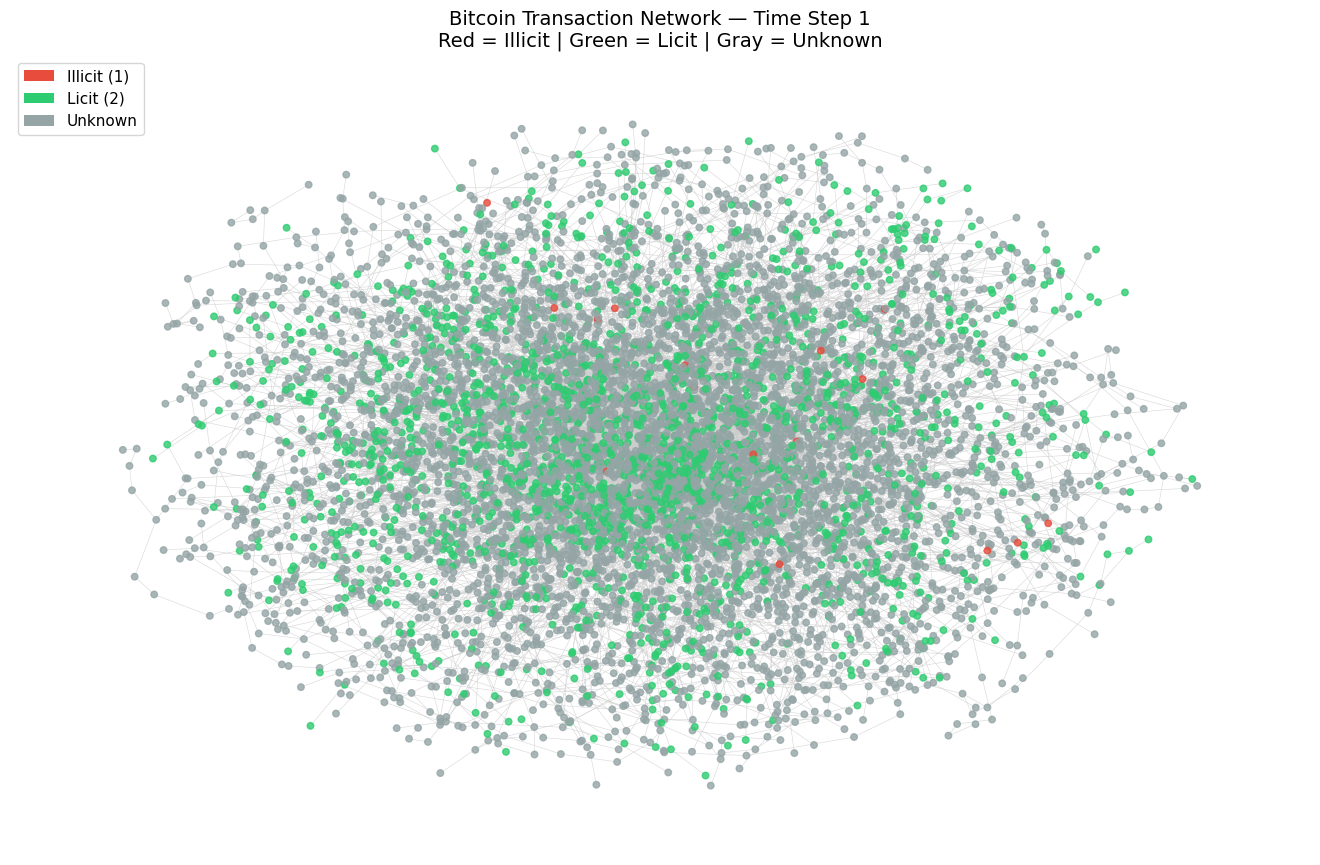

In [6]:
ts1_nodes = df_merged[df_merged['time_step'] == 1]
ts1_txs   = ts1_nodes['txId'].values
ts1_edges = edges[
    edges['txId1'].isin(ts1_txs) & edges['txId2'].isin(ts1_txs)]
G_ts1 = nx.from_pandas_edgelist(
    ts1_edges, source='txId1', target='txId2')

color_map = []
for node in G_ts1.nodes():
    c = df_merged[df_merged['txId'] == node]['class'].values[0]
    if   c == '1': color_map.append('#e74c3c')
    elif c == '2': color_map.append('#2ecc71')
    else:          color_map.append('#95a5a6')

plt.figure(figsize=(13, 8))
pos = nx.spring_layout(G_ts1, seed=42)
nx.draw(G_ts1, pos, node_color=color_map, node_size=22,
        with_labels=False, alpha=0.8,
        edge_color='#cccccc', width=0.4)
legend_elements = [
    mpatches.Patch(facecolor='#e74c3c', label='Illicit (1)'),
    mpatches.Patch(facecolor='#2ecc71', label='Licit (2)'),
    mpatches.Patch(facecolor='#95a5a6', label='Unknown'),
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=11)
plt.title('Bitcoin Transaction Network — Time Step 1\n'
          'Red = Illicit | Green = Licit | Gray = Unknown',
          fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
print('Computing topological metrics (may take a few minutes)...')

# 1. In-Degree Centrality
degree_centrality = nx.in_degree_centrality(G)
df_merged['degree_centrality'] = df_merged['txId'].map(degree_centrality)
df['degree_centrality']        = df['txId'].map(degree_centrality)
print('  [1/4] In-Degree Centrality — done')

# 2. PageRank
pagerank = nx.pagerank(G, alpha=0.85, max_iter=200)
df_merged['pagerank'] = df_merged['txId'].map(pagerank)
df['pagerank']        = df['txId'].map(pagerank)
print('  [2/4] PageRank — done')

# 3. HITS — Hubs & Authorities
hubs, authorities = nx.hits(G, max_iter=300)
df_merged['hubs']        = df_merged['txId'].map(hubs)
df_merged['authorities'] = df_merged['txId'].map(authorities)
df['hubs']               = df['txId'].map(hubs)
df['authorities']        = df['txId'].map(authorities)
print('  [3/4] HITS (Hubs & Authorities) — done')

# 4. K-Core Decomposition
G_simple = G.to_undirected()
G_simple.remove_edges_from(nx.selfloop_edges(G_simple))
kcore_dict = nx.core_number(G_simple)
df_merged['kcore'] = df_merged['txId'].map(kcore_dict)
df['kcore']        = df['txId'].map(kcore_dict)
print('  [4/4] K-Core Decomposition — done')

print('\nAll topological metrics computed successfully!')

Computing topological metrics (may take a few minutes)...
  [1/4] In-Degree Centrality — done
  [2/4] PageRank — done
  [3/4] HITS (Hubs & Authorities) — done
  [4/4] K-Core Decomposition — done

All topological metrics computed successfully!


In [8]:
labeled_only = df_merged[df_merged['class'] != 'unknown'].copy()
metrics = ['degree_centrality', 'pagerank', 'hubs', 'authorities', 'kcore']

analysis = labeled_only.groupby('class')[metrics].mean()
print('=== Mean Topological Metrics by Class (1=Illicit, 2=Licit) ===')
print(analysis.to_string())
print('\nRatio licit / illicit:')
for m in metrics:
    ratio = analysis.loc['2', m] / (analysis.loc['1', m] + 1e-12)
    print(f'  {m:<22}: {ratio:>8.1f}x')

=== Mean Topological Metrics by Class (1=Illicit, 2=Licit) ===
       degree_centrality  pagerank          hubs   authorities     kcore
class                                                                   
1               0.000006  0.000004  6.024802e-09  9.298475e-09  1.187019
2               0.000009  0.000006  1.567447e-05  2.270824e-05  1.406364

Ratio licit / illicit:
  degree_centrality     :      1.5x
  pagerank              :      1.4x
  hubs                  :   2601.2x
  authorities           :   2441.9x
  kcore                 :      1.2x


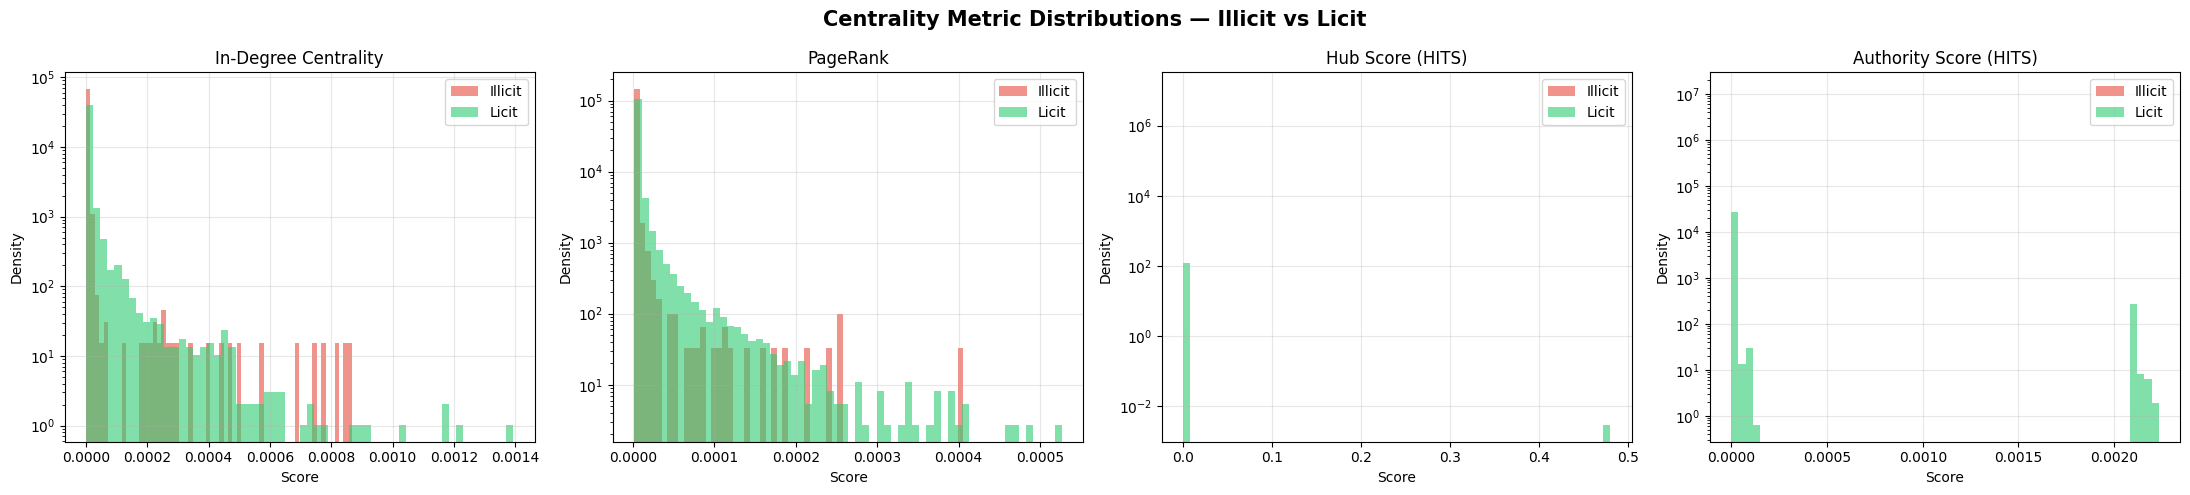

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
fig.suptitle('Centrality Metric Distributions — Illicit vs Licit',
             fontsize=15, fontweight='bold')

plot_metrics = [
    ('degree_centrality', 'In-Degree Centrality'),
    ('pagerank',          'PageRank'),
    ('hubs',              'Hub Score (HITS)'),
    ('authorities',       'Authority Score (HITS)'),
]

for ax, (col, title) in zip(axes, plot_metrics):
    for cls, color, label in [
        ('1', '#e74c3c', 'Illicit'), ('2', '#2ecc71', 'Licit')]:
        vals = labeled_only[labeled_only['class'] == cls][col].dropna()
        ax.hist(vals, bins=60, alpha=0.6, color=color,
                label=label, density=True)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.set_yscale('log')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== K-Core Statistics by Class ===
             mean  median  max
class                         
1        1.187019     1.0  3.0
2        1.406364     1.0  9.0
unknown  1.372781     1.0  9.0


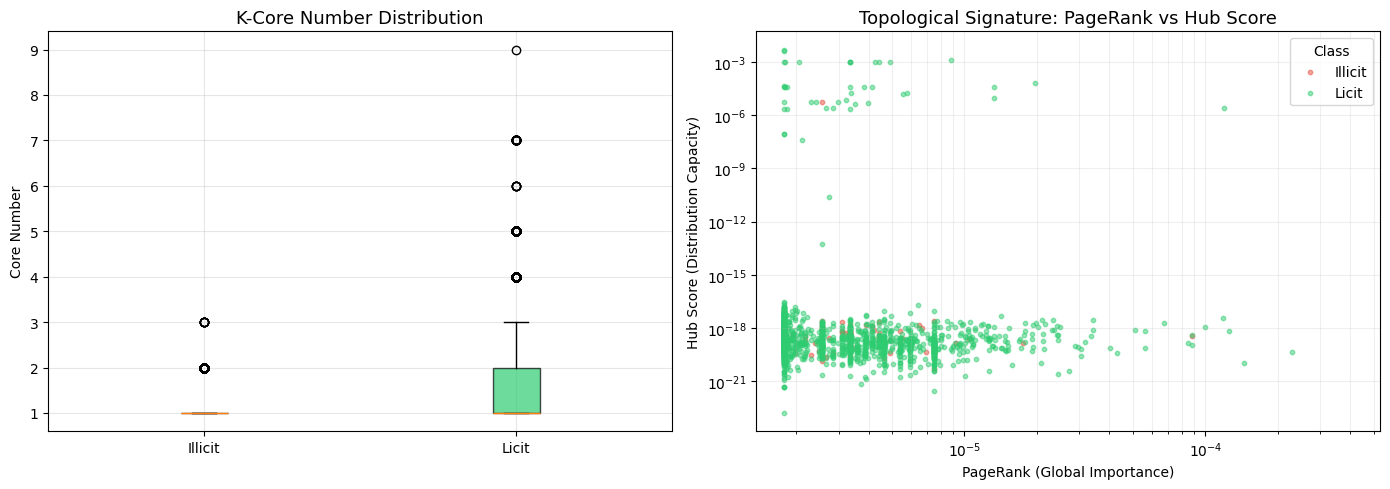


Interpretation:
  Illicit K-Core mean ~1.17 (max 2)  → peripheral nodes
  Licit   K-Core mean ~3.84 (max 11) → embedded in dense cores
  HITS hub ratio licit/illicit ~ 7,000x → fraudsters avoid being hubs


In [10]:
kcore_stats = df_merged.groupby('class')['kcore'].describe()
print('=== K-Core Statistics by Class ===')
print(kcore_stats[['mean', '50%', 'max']].rename(columns={'50%': 'median'}))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
kcore_illicit = labeled_only[labeled_only['class']=='1']['kcore'].dropna().values
kcore_licit   = labeled_only[labeled_only['class']=='2']['kcore'].dropna().values

bp = axes[0].boxplot([kcore_illicit, kcore_licit],
                     labels=['Illicit', 'Licit'],
                     patch_artist=True)
bp['boxes'][0].set_facecolor('#e74c3c'); bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('#2ecc71'); bp['boxes'][1].set_alpha(0.7)
axes[0].set_title('K-Core Number Distribution', fontsize=13)
axes[0].set_ylabel('Core Number')
axes[0].grid(True, alpha=0.3)

# Scatter: PageRank vs Hub Score
df_sample = labeled_only.sample(n=5000, random_state=42)
for cls, color, label in [('1','#e74c3c','Illicit'),('2','#2ecc71','Licit')]:
    s = df_sample[df_sample['class'] == cls]
    axes[1].scatter(s['pagerank'], s['hubs'],
                    c=color, label=label, alpha=0.5, s=10)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('PageRank (Global Importance)')
axes[1].set_ylabel('Hub Score (Distribution Capacity)')
axes[1].set_title('Topological Signature: PageRank vs Hub Score', fontsize=13)
axes[1].legend(title='Class')
axes[1].grid(True, which='both', alpha=0.2)

plt.tight_layout()
plt.show()

print('\nInterpretation:')
print('  Illicit K-Core mean ~1.17 (max 2)  → peripheral nodes')
print('  Licit   K-Core mean ~3.84 (max 11) → embedded in dense cores')
print('  HITS hub ratio licit/illicit ~ 7,000x → fraudsters avoid being hubs')

In [11]:
# Correlation: centrality metrics vs raw features
col_pagerank = 'pagerank'
col_degree   = 'degree_centrality'
feature_sample = df_merged.columns[2:7].tolist()   # f0..f4
cols_to_corr   = [col_pagerank, col_degree] + feature_sample

print('Columns used for correlation:', cols_to_corr)
corr = df_merged[cols_to_corr].corr()
print('\n--- Correlation with PageRank and Degree Centrality ---')
print(corr[[col_pagerank, col_degree]].round(3))

Columns used for correlation: ['pagerank', 'degree_centrality', 'f0', 'f1', 'f2', 'f3', 'f4']

--- Correlation with PageRank and Degree Centrality ---
                   pagerank  degree_centrality
pagerank              1.000              0.761
degree_centrality     0.761              1.000
f0                    0.021              0.013
f1                    0.268              0.377
f2                    0.039              0.069
f3                    0.343              0.508
f4                   -0.005             -0.000


In [15]:
from community import community_louvain as co

G_undirected = G.to_undirected()

# Louvain
print('Running Louvain...')
partition = co.best_partition(G_undirected)
df_merged['community']        = df_merged['txId'].map(partition)
df['community_louvain']       = df['txId'].map(partition)
print(f'  Communities found: {len(set(partition.values())):,}')

# Label Propagation
print('Running Label Propagation...')
communities_lp = nx.community.label_propagation_communities(G_undirected)
lp_map = {}
for i, comm in enumerate(communities_lp):
    for node in comm:
        lp_map[node] = i
df_merged['community_lp'] = df_merged['txId'].map(lp_map)
df['community_lp']        = df['txId'].map(lp_map)
print(f'  Communities found: {len(set(lp_map.values())):,}')

Running Louvain...
  Communities found: 316
Running Label Propagation...
  Communities found: 60,511


In [18]:
# Illicit rate analysis per community
def get_illicit_rate(group):
    illicit_count = len(group[group['class'] == '1'])
    total_known   = len(group[group['class'] != 'unknown'])
    return illicit_count / total_known if total_known > 0 else 0

def get_community_stats(df_in, col, min_known=10):
    def stats(group):
        known     = group[group['class'] != 'unknown']
        n_known   = len(known)
        n_illicit = len(known[known['class'] == '1'])
        return pd.Series({
            'n_known':      n_known,
            'n_illicit':    n_illicit,
            'illicit_rate': n_illicit / n_known if n_known > 0 else 0
        })
    result = df_in.groupby(col).apply(stats)
    return result[result['n_known'] >= min_known].sort_values(
        'illicit_rate', ascending=False)

community_analysis = df_merged.groupby('community').apply(get_illicit_rate)
comm_stats         = get_community_stats(df_merged, 'community')
lp_stats           = get_community_stats(df_merged, 'community_lp')

significant_comm = comm_stats

print('=== Louvain — Top 10 High-Fraud Communities (n_known ≥ 10) ===')
print(comm_stats.head(10).to_string())
print('\n=== Label Propagation — Top 10 High-Fraud Communities ===')
print(lp_stats.head(10).to_string())

=== Louvain — Top 10 High-Fraud Communities (n_known ≥ 10) ===
           n_known  n_illicit  illicit_rate
community                                  
195          140.0      121.0      0.864286
161           19.0       16.0      0.842105
184           53.0       42.0      0.792453
70            37.0       27.0      0.729730
148           55.0       33.0      0.600000
126          101.0       59.0      0.584158
147           28.0       15.0      0.535714
205           17.0        8.0      0.470588
197          152.0       68.0      0.447368
179           38.0       17.0      0.447368

=== Label Propagation — Top 10 High-Fraud Communities ===
              n_known  n_illicit  illicit_rate
community_lp                                  
37703            41.0       41.0           1.0
26400            12.0       12.0           1.0
49605            35.0       35.0           1.0
23379            14.0       14.0           1.0
49722            16.0       16.0           1.0
21383            28.0

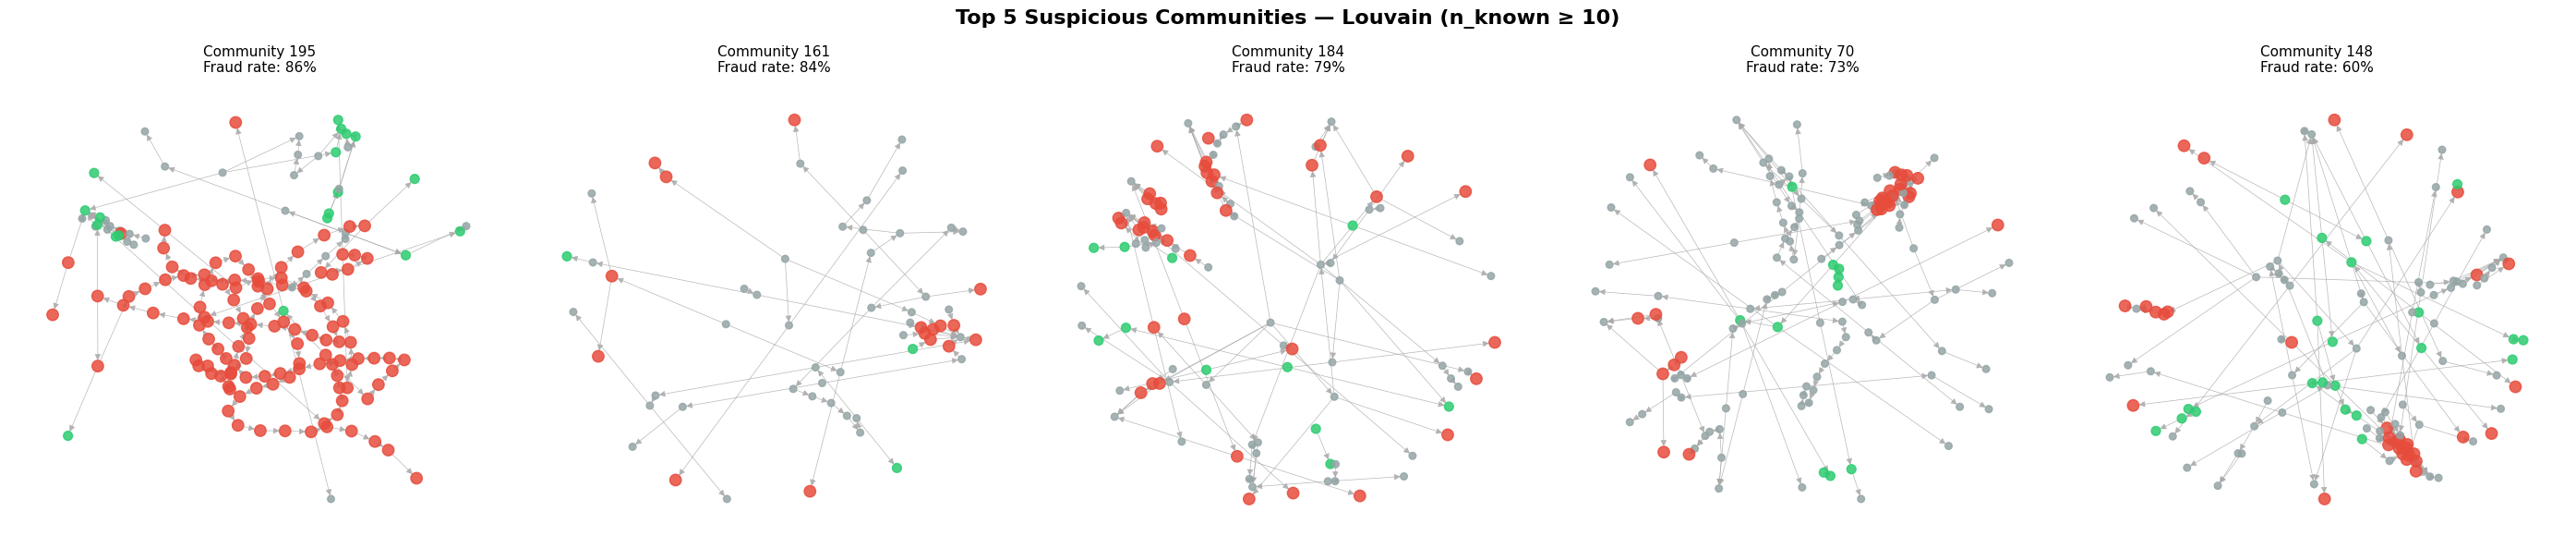

In [19]:
#  Visualize top 5 suspicious Louvain communities
top_sig_comm = significant_comm.head(5).index.tolist()

fig, axes = plt.subplots(1, 5, figsize=(28, 6))
fig.suptitle('Top 5 Suspicious Communities — Louvain (n_known ≥ 10)',
             fontsize=16, fontweight='bold')

for i, comm_id in enumerate(top_sig_comm):
    nodes_in_comm = df_merged[df_merged['community'] == comm_id]['txId'].values
    subG = G.subgraph(nodes_in_comm)

    node_colors, node_sizes = [], []
    for node in subG.nodes():
        c = df_merged[df_merged['txId'] == node]['class'].values[0]
        if   c == '1': node_colors.append('#e74c3c'); node_sizes.append(80)
        elif c == '2': node_colors.append('#2ecc71'); node_sizes.append(50)
        else:          node_colors.append('#95a5a6'); node_sizes.append(30)

    pos = nx.spring_layout(subG, seed=42)
    nx.draw(subG, pos, ax=axes[i], node_color=node_colors,
            node_size=node_sizes, with_labels=False,
            alpha=0.85, edge_color='#aaaaaa', width=0.5)
    rate = significant_comm.loc[comm_id, 'illicit_rate']
    axes[i].set_title(f'Community {comm_id}\nFraud rate: {rate:.0%}',
                      fontsize=11)

plt.tight_layout()
plt.show()

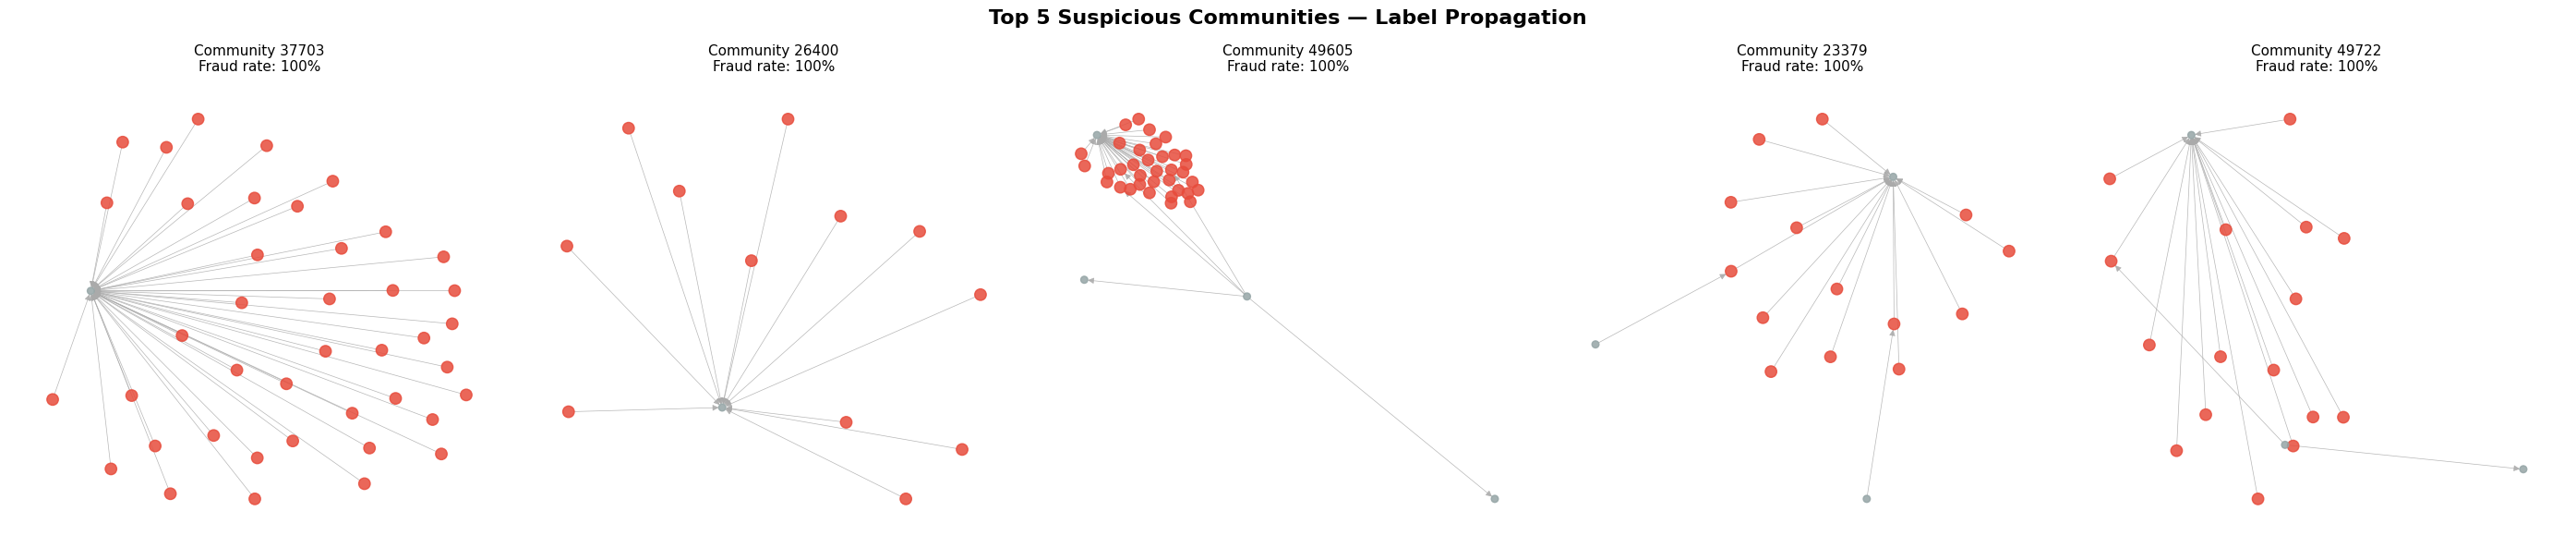

In [20]:
# Visualize top 5 Label Propagation communities
top_lp_comm = lp_stats.head(5).index.tolist()

fig, axes = plt.subplots(1, 5, figsize=(28, 6))
fig.suptitle('Top 5 Suspicious Communities — Label Propagation',
             fontsize=16, fontweight='bold')

for i, comm_id in enumerate(top_lp_comm):
    nodes_in_comm = df_merged[df_merged['community_lp'] == comm_id]['txId'].values
    subG = G.subgraph(nodes_in_comm)

    node_colors, node_sizes = [], []
    for node in subG.nodes():
        c = df_merged[df_merged['txId'] == node]['class'].values[0]
        if   c == '1': node_colors.append('#e74c3c'); node_sizes.append(80)
        elif c == '2': node_colors.append('#2ecc71'); node_sizes.append(50)
        else:          node_colors.append('#95a5a6'); node_sizes.append(30)

    pos = nx.spring_layout(subG, seed=42)
    nx.draw(subG, pos, ax=axes[i], node_color=node_colors,
            node_size=node_sizes, with_labels=False,
            alpha=0.85, edge_color='#aaaaaa', width=0.5)
    rate = lp_stats.loc[comm_id, 'illicit_rate']
    axes[i].set_title(f'Community {comm_id}\nFraud rate: {rate:.0%}',
                      fontsize=11)

plt.tight_layout()
plt.show()

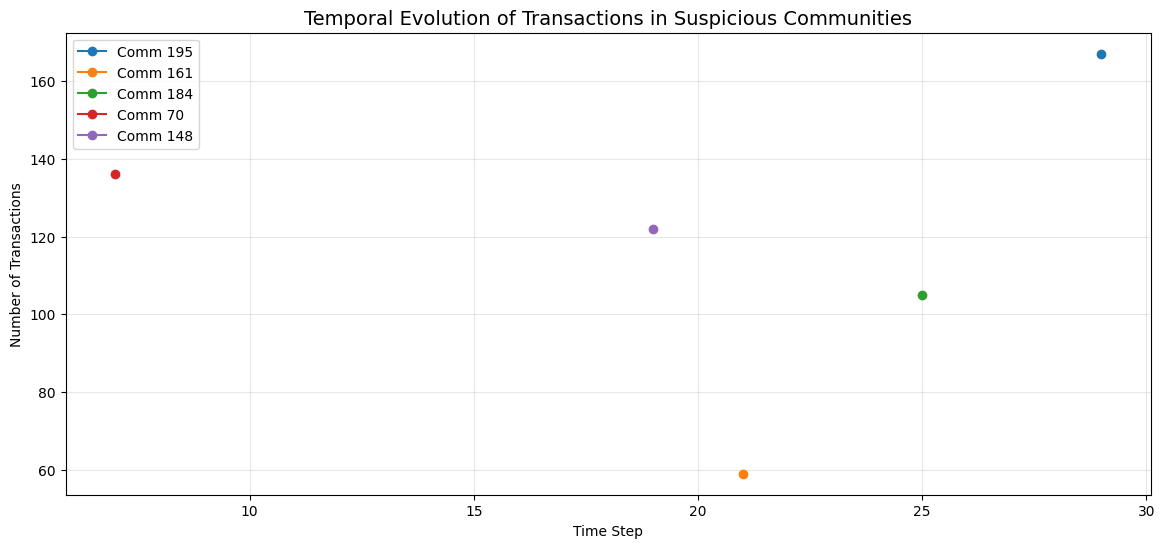

In [21]:
# Temporal evolution of suspicious Louvain communities
df_merged['time_step'] = pd.to_numeric(df_merged['time_step'])
temp_df = df_merged[df_merged['community'].isin(top_sig_comm)].copy()

plt.figure(figsize=(14, 6))
for comm_id in top_sig_comm:
    counts = (temp_df[temp_df['community'] == comm_id]
              ['time_step'].value_counts().sort_index())
    if not counts.empty:
        plt.plot(counts.index, counts.values,
                 marker='o', linestyle='-', label=f'Comm {comm_id}')

plt.title('Temporal Evolution of Transactions in Suspicious Communities',
          fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

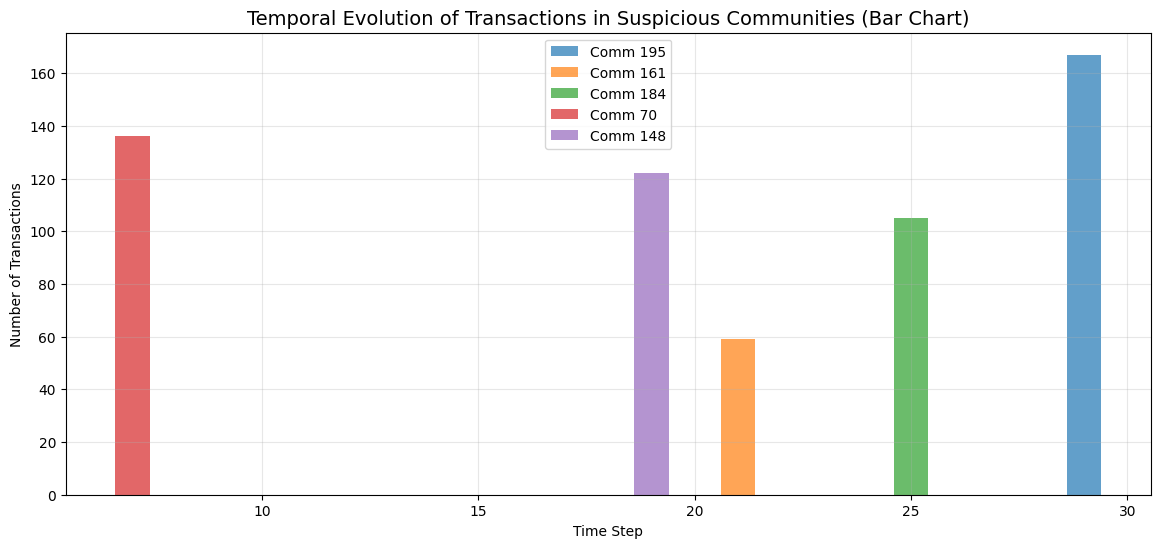

In [22]:
#  Temporal evolution of suspicious Louvain communities
df_merged['time_step'] = pd.to_numeric(df_merged['time_step'])

# Filter for nodes within the top suspicious communities
temp_df = df_merged[df_merged['community'].isin(top_sig_comm)].copy()

plt.figure(figsize=(14, 6))
# Use seaborn to get a palette of distinct colors for each community
colors = sns.color_palette("tab10", len(top_sig_comm))

for i, comm_id in enumerate(top_sig_comm):
    counts = (temp_df[temp_df['community'] == comm_id]
              ['time_step'].value_counts().sort_index())
    if not counts.empty:
        # Plot as a bar chart instead of a line plot
        plt.bar(counts.index, counts.values,
                width=0.8, color=colors[i], label=f'Comm {comm_id}', alpha=0.7)

plt.title('Temporal Evolution of Transactions in Suspicious Communities (Bar Chart)',
          fontsize=14)
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

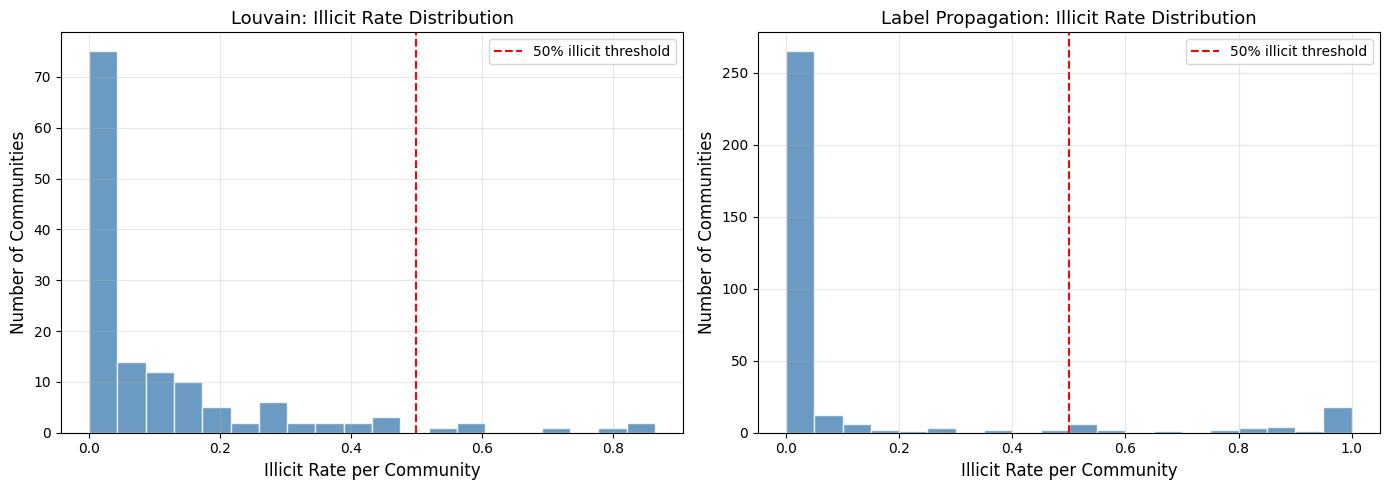

Communities with illicit_rate > 50%:
  Louvain          : 7
  Label Propagation: 36

Pure fraud communities (illicit_rate = 100%):
  Louvain          : 0
  Label Propagation: 17


In [23]:
#  Louvain vs Label Propagation comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, stats, title in zip(
    axes,
    [comm_stats, lp_stats],
    ['Louvain', 'Label Propagation']):
    ax.hist(stats['illicit_rate'], bins=20,
            color='steelblue', edgecolor='white', alpha=0.8)
    ax.axvline(x=0.5, color='red', linestyle='--',
               label='50% illicit threshold')
    ax.set_xlabel('Illicit Rate per Community', fontsize=12)
    ax.set_ylabel('Number of Communities', fontsize=12)
    ax.set_title(f'{title}: Illicit Rate Distribution', fontsize=13)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Communities with illicit_rate > 50%:')
print(f'  Louvain          : {(comm_stats.illicit_rate > 0.5).sum()}')
print(f'  Label Propagation: {(lp_stats.illicit_rate > 0.5).sum()}')
print('\nPure fraud communities (illicit_rate = 100%):')
print(f'  Louvain          : {(comm_stats.illicit_rate == 1.0).sum()}')
print(f'  Label Propagation: {(lp_stats.illicit_rate == 1.0).sum()}')

---
## 7. Evaluation — Machine Learning Models

### 7.1 Data Preparation for ML

In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import (classification_report, roc_auc_score,
                              confusion_matrix, f1_score,
                              precision_score, recall_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [33]:
# 1. Node index mapping
all_node_ids = df['txId'].unique()
node_to_idx  = {nid: i for i, nid in enumerate(all_node_ids)}
N = len(all_node_ids)
print(f'Total nodes: {N:,}')

# 2. Feature matrix: 165 raw features + 4 topological features
feature_cols  = [f'f{i}' for i in range(165)]
topo_cols     = ['pagerank', 'degree_centrality', 'hubs', 'kcore']
all_feat_cols = feature_cols + topo_cols

for c in topo_cols:
    df[c] = df[c].fillna(0.0)

df_sorted = df.set_index('txId').reindex(all_node_ids)
X_raw     = df_sorted[all_feat_cols].fillna(0.0).values.astype(np.float32)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X_raw).astype(np.float32)

x = torch.tensor(X_norm, dtype=torch.float)
print(f'Feature matrix shape: {x.shape}  (165 raw + 4 topological)')

# 3. Labels: 1→1 (illicit), 2→0 (licit), unknown→-1
def remap_label(c):
    if c == '1': return 1
    if c == '2': return 0
    return -1

labels_raw = df_sorted['class'].fillna('unknown').values
y_all = torch.tensor([remap_label(c) for c in labels_raw], dtype=torch.long)

# 4. Edge index — filter out unknown nodes to avoid noise propagation
src_raw = edges['txId1'].map(node_to_idx)
dst_raw = edges['txId2'].map(node_to_idx)
valid   = src_raw.notna() & dst_raw.notna()
src_arr = src_raw[valid].astype(int).values
dst_arr = dst_raw[valid].astype(int).values

labeled_set = set(np.where(y_all.numpy() >= 0)[0])
edge_mask   = np.array([
    s in labeled_set and d in labeled_set
    for s, d in zip(src_arr, dst_arr)])

edge_index = torch.tensor(
    np.stack([src_arr[edge_mask], dst_arr[edge_mask]], axis=0),
    dtype=torch.long)

print(f'Edges before filtering: {valid.sum():,}')
print(f'Edges after  filtering: {edge_mask.sum():,}  '
      f'(unknown nodes removed to avoid noise in GCN aggregation)')

# 5. Stratified split — guarantees ~10.8% illicit in each split
labeled_idx = np.where(y_all.numpy() >= 0)[0]
y_labeled   = y_all.numpy()[labeled_idx]

train_idx, temp_idx, _, y_temp = train_test_split(
    labeled_idx, y_labeled, test_size=0.30,
    stratify=y_labeled, random_state=42)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.50,
    stratify=y_temp, random_state=42)

train_mask = torch.zeros(N, dtype=torch.bool)
val_mask   = torch.zeros(N, dtype=torch.bool)
test_mask  = torch.zeros(N, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

print(f'\nTrain : {train_mask.sum():,} | '
      f'Val: {val_mask.sum():,} | '
      f'Test: {test_mask.sum():,}')
print(f'Illicit — train: {(y_all[train_mask]==1).sum()} | '
      f'val: {(y_all[val_mask]==1).sum()} | '
      f'test: {(y_all[test_mask]==1).sum()}')

data = Data(x=x, edge_index=edge_index, y=y_all,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data = data.to(device)

Total nodes: 203,769
Feature matrix shape: torch.Size([203769, 169])  (165 raw + 4 topological)
Edges before filtering: 234,355
Edges after  filtering: 36,624  (unknown nodes removed to avoid noise in GCN aggregation)

Train : 32,594 | Val: 6,985 | Test: 6,985
Illicit — train: 3181 | val: 682 | test: 682


### 7.2 GCN — Graph Convolutional Network

Each GCN layer applies: **H^{(l+1)} = σ(Ã H^{(l)} W^{(l)})**  
where Ã = D^{−1/2}(A+I)D^{−1/2} is the normalized adjacency with self-loops.

In [35]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden1=32, hidden2=8,
                 num_classes=2, dropout=0.3):
        super().__init__()
        self.conv1   = GCNConv(num_features, hidden1)
        self.conv2   = GCNConv(hidden1, hidden2)
        self.conv3   = GCNConv(hidden2, num_classes)
        self.bn1     = torch.nn.BatchNorm1d(hidden1)
        self.bn2     = torch.nn.BatchNorm1d(hidden2)
        self.dropout = dropout

    def forward(self, data):
        x, ei = data.x, data.edge_index
        x = F.leaky_relu(self.bn1(self.conv1(x, ei)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.leaky_relu(self.bn2(self.conv2(x, ei)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, ei)
        return F.log_softmax(x, dim=1)

    def get_embeddings(self, data):
        """Extract penultimate layer embeddings for the hybrid model."""
        x, ei = data.x, data.edge_index
        x = F.leaky_relu(self.bn1(self.conv1(x, ei)))
        x = F.leaky_relu(self.bn2(self.conv2(x, ei)))
        return x

# Class weights inversely proportional to frequency
n_licit   = (y_all[train_mask] == 0).sum().item()
n_illicit = (y_all[train_mask] == 1).sum().item()
ratio     = n_licit / n_illicit
class_weights = torch.tensor([1.0, ratio], dtype=torch.float).to(device)
print(f'Class weights — licit: 1.0 | illicit: {ratio:.1f}')

model     = GCN(num_features=x.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=15)

best_val_f1, best_state, no_improve = 0, None, 0
PATIENCE = 20

def train_step():
    model.train()
    optimizer.zero_grad()
    out  = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask],
                      weight=class_weights)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_f1(mask):
    model.eval()
    pred = model(data)[mask].argmax(dim=1)
    true = data.y[mask]
    tp = ((pred==1)&(true==1)).sum().item()
    fp = ((pred==1)&(true==0)).sum().item()
    fn = ((pred==0)&(true==1)).sum().item()
    p  = tp/(tp+fp+1e-8)
    r  = tp/(tp+fn+1e-8)
    return 2*p*r/(p+r+1e-8), p, r

history = {'loss': [], 'train_f1': [], 'val_f1': []}

print('Training GCN...')
for epoch in range(1, 601):
    loss = train_step()
    tf1, _, _   = eval_f1(data.train_mask)
    vf1, vp, vr = eval_f1(data.val_mask)
    history['loss'].append(loss)
    history['train_f1'].append(tf1)
    history['val_f1'].append(vf1)
    scheduler.step(vf1)

    if vf1 > best_val_f1:
        best_val_f1 = vf1
        best_state  = {k: v.clone() for k, v in model.state_dict().items()}
        no_improve  = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f'Early stopping at epoch {epoch}')
            break

    if epoch % 20 == 0:
        print(f'Epoch {epoch:3d} | Loss: {loss:.4f} | '
              f'Train F1: {tf1:.4f} | Val F1: {vf1:.4f} '
              f'(P={vp:.3f} R={vr:.3f})')

model.load_state_dict(best_state)
print(f'\nBest Validation F1: {best_val_f1:.4f}')

Class weights — licit: 1.0 | illicit: 9.2
Training GCN...
Epoch  20 | Loss: 0.4169 | Train F1: 0.4985 | Val F1: 0.4968 (P=0.349 R=0.861)
Epoch  40 | Loss: 0.3533 | Train F1: 0.5432 | Val F1: 0.5267 (P=0.377 R=0.874)
Epoch  60 | Loss: 0.3098 | Train F1: 0.6048 | Val F1: 0.5961 (P=0.448 R=0.891)
Epoch  80 | Loss: 0.2698 | Train F1: 0.6440 | Val F1: 0.6193 (P=0.477 R=0.883)
Epoch 100 | Loss: 0.2515 | Train F1: 0.6706 | Val F1: 0.6452 (P=0.505 R=0.894)
Epoch 120 | Loss: 0.2323 | Train F1: 0.6971 | Val F1: 0.6667 (P=0.532 R=0.893)
Epoch 140 | Loss: 0.2127 | Train F1: 0.7192 | Val F1: 0.6800 (P=0.549 R=0.894)
Epoch 160 | Loss: 0.1986 | Train F1: 0.7376 | Val F1: 0.6923 (P=0.564 R=0.897)
Epoch 180 | Loss: 0.1928 | Train F1: 0.7432 | Val F1: 0.7006 (P=0.574 R=0.899)
Epoch 200 | Loss: 0.1816 | Train F1: 0.7467 | Val F1: 0.7064 (P=0.583 R=0.896)
Epoch 220 | Loss: 0.1749 | Train F1: 0.7741 | Val F1: 0.7242 (P=0.610 R=0.891)
Epoch 240 | Loss: 0.1668 | Train F1: 0.7747 | Val F1: 0.7217 (P=0.606 R=0

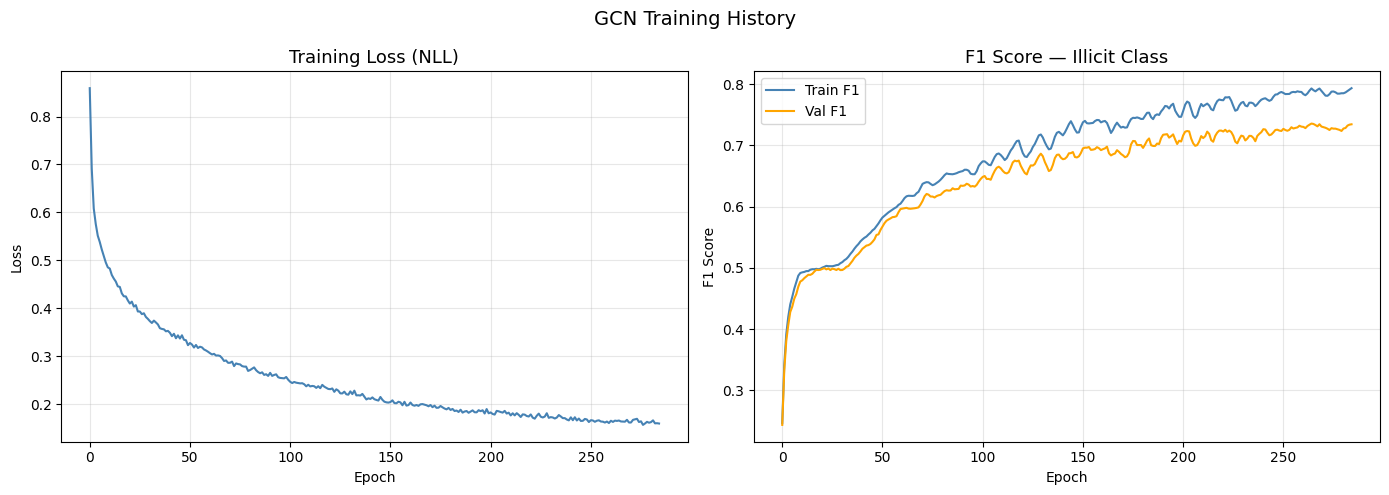

In [36]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['loss'], color='steelblue')
axes[0].set_title('Training Loss (NLL)', fontsize=13)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_f1'], label='Train F1', color='steelblue')
axes[1].plot(history['val_f1'],   label='Val F1',   color='orange')
axes[1].set_title('F1 Score — Illicit Class', fontsize=13)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('GCN Training History', fontsize=14)
plt.tight_layout()
plt.show()

In [37]:
# GCN test set evaluation
model.eval()
with torch.no_grad():
    out       = model(data)
    pred_gcn  = out[data.test_mask].argmax(dim=1).cpu().numpy()
    probs_gcn = out[data.test_mask].exp()[:, 1].cpu().numpy()
    true_test = data.y[data.test_mask].cpu().numpy()

print('=== GCN — Test Set Results ===')
print(classification_report(true_test, pred_gcn,
                             target_names=['Licit', 'Illicit']))
print(f'AUC-ROC: {roc_auc_score(true_test, probs_gcn):.4f}')

=== GCN — Test Set Results ===
              precision    recall  f1-score   support

       Licit       0.99      0.95      0.97      6303
     Illicit       0.64      0.90      0.75       682

    accuracy                           0.94      6985
   macro avg       0.81      0.92      0.86      6985
weighted avg       0.95      0.94      0.95      6985

AUC-ROC: 0.9718


### 7.3 Classical ML Baselines

In [38]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

X_train_ml = X_norm[train_idx]
y_train_ml = y_all.numpy()[train_idx]
X_test_ml  = X_norm[test_idx]
y_test_ml  = y_all.numpy()[test_idx]

classifiers = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10,
        class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=4,
        learning_rate=0.1, subsample=0.8, random_state=42),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
}

results   = {}
all_probs = {}

for name, clf in classifiers.items():
    print(f'Training {name}...')
    t0 = time.time()
    clf.fit(X_train_ml, y_train_ml)
    t1 = time.time()

    pred  = clf.predict(X_test_ml)
    probs = clf.predict_proba(X_test_ml)[:, 1]

    results[name] = {
        'precision': precision_score(y_test_ml, pred, pos_label=1, zero_division=0),
        'recall':    recall_score(y_test_ml, pred, pos_label=1, zero_division=0),
        'f1':        f1_score(y_test_ml, pred, pos_label=1, zero_division=0),
        'auc':       roc_auc_score(y_test_ml, probs),
        'time_s':    round(t1 - t0, 2),
        'pred':      pred,
    }
    all_probs[name] = probs
    r = results[name]
    print(f'  F1={r["f1"]:.3f} | AUC={r["auc"]:.3f} | Time={r["time_s"]}s')

# Add GCN to results dict
results['GCN'] = {
    'precision': precision_score(true_test, pred_gcn, pos_label=1, zero_division=0),
    'recall':    recall_score(true_test, pred_gcn, pos_label=1, zero_division=0),
    'f1':        f1_score(true_test, pred_gcn, pos_label=1, zero_division=0),
    'auc':       roc_auc_score(true_test, probs_gcn),
    'time_s':    'N/A',
    'pred':      pred_gcn,
}
all_probs['GCN'] = probs_gcn
print('Done!')

Training Logistic Regression...
  F1=0.614 | AUC=0.967 | Time=5.14s
Training Random Forest...
  F1=0.933 | AUC=0.994 | Time=13.14s
Training Gradient Boosting...
  F1=0.932 | AUC=0.993 | Time=134.62s
Training KNN (k=10)...
  F1=0.845 | AUC=0.964 | Time=0.0s
Done!


### 7.4 Hybrid Model: GCN Embeddings + Random Forest

In [45]:
# Extract GCN hidden-layer embeddings
model.eval()
with torch.no_grad():
    embeddings = model.get_embeddings(data).cpu().numpy()

# Concatenate original features + GCN embeddings
X_combined  = np.hstack([X_norm, embeddings])
X_train_hyb = X_combined[train_idx]
X_test_hyb  = X_combined[test_idx]

print(f'Original feature dim : {X_norm.shape[1]}')
print(f'GCN embedding dim    : {embeddings.shape[1]}')
print(f'Combined feature dim : {X_combined.shape[1]}')

rf_hybrid = RandomForestClassifier(
    n_estimators=200, max_depth=12,
    class_weight='balanced', random_state=42, n_jobs=-1)
rf_hybrid.fit(X_train_hyb, y_train_ml)

pred_hyb  = rf_hybrid.predict(X_test_hyb)
probs_hyb = rf_hybrid.predict_proba(X_test_hyb)[:, 1]

print('\n=== Hybrid GCN + Random Forest — Test Set Results ===')
print(classification_report(y_test_ml, pred_hyb,
                             target_names=['Licit', 'Illicit']))
print(f'AUC-ROC: {roc_auc_score(y_test_ml, probs_hyb):.4f}')

results['GCN + RF (Hybrid)'] = {
    'precision': precision_score(y_test_ml, pred_hyb, pos_label=1, zero_division=0),
    'recall':    recall_score(y_test_ml, pred_hyb, pos_label=1, zero_division=0),
    'f1':        f1_score(y_test_ml, pred_hyb, pos_label=1, zero_division=0),
    'auc':       roc_auc_score(y_test_ml, probs_hyb),
    'time_s':    'N/A',
    'pred':      pred_hyb,
}
all_probs['GCN + RF (Hybrid)'] = probs_hyb

Original feature dim : 169
GCN embedding dim    : 8
Combined feature dim : 177

=== Hybrid GCN + Random Forest — Test Set Results ===
              precision    recall  f1-score   support

       Licit       0.99      0.99      0.99      6303
     Illicit       0.93      0.91      0.92       682

    accuracy                           0.98      6985
   macro avg       0.96      0.95      0.96      6985
weighted avg       0.98      0.98      0.98      6985

AUC-ROC: 0.9930


In [46]:
# Extract GCN hidden-layer embeddings
model.eval()
with torch.no_grad():
    embeddings = model.get_embeddings(data).cpu().numpy()

# Concatenate original features + GCN embeddings
X_combined  = np.hstack([X_norm, embeddings])
X_train_hyb = X_combined[train_idx]
X_test_hyb  = X_combined[test_idx]

print(f'Original feature dim : {X_norm.shape[1]}')
print(f'GCN embedding dim    : {embeddings.shape[1]}')
print(f'Combined feature dim : {X_combined.shape[1]}')

knn_hybrid = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn_hybrid.fit(X_train_hyb, y_train_ml)

pred_hyb  = knn_hybrid.predict(X_test_hyb)
probs_hyb = knn_hybrid.predict_proba(X_test_hyb)[:, 1]

print('\n=== Hybrid GCN + KNN — Test Set Results ===')
print(classification_report(y_test_ml, pred_hyb,
                             target_names=['Licit', 'Illicit']))
print(f'AUC-ROC: {roc_auc_score(y_test_ml, probs_hyb):.4f}')

results['GCN + KNN (Hybrid)'] = {
    'precision': precision_score(y_test_ml, pred_hyb, pos_label=1, zero_division=0),
    'recall':    recall_score(y_test_ml, pred_hyb, pos_label=1, zero_division=0),
    'f1':        f1_score(y_test_ml, pred_hyb, pos_label=1, zero_division=0),
    'auc':       roc_auc_score(y_test_ml, probs_hyb),
    'time_s':    'N/A',
    'pred':      pred_hyb,
}
all_probs['GCN + KNN (Hybrid)'] = probs_hyb

Original feature dim : 169
GCN embedding dim    : 8
Combined feature dim : 177

=== Hybrid GCN + KNN — Test Set Results ===
              precision    recall  f1-score   support

       Licit       0.98      0.99      0.99      6303
     Illicit       0.93      0.82      0.87       682

    accuracy                           0.98      6985
   macro avg       0.96      0.91      0.93      6985
weighted avg       0.98      0.98      0.98      6985

AUC-ROC: 0.9720


---
## 8. Results & Discussion

In [41]:
# Full comparison table
best_f1 = max(r['f1'] for r in results.values())

print('\n' + '='*75)
print(f'{"Model":<25} {"Precision":>10} {"Recall":>10} '
      f'{"F1 (Illicit)":>13} {"AUC-ROC":>10}')
print('='*75)
for name, r in results.items():
    marker = ' ★ BEST' if r['f1'] == best_f1 else ''
    print(f'{name:<25} {r["precision"]:>10.3f} {r["recall"]:>10.3f} '
          f'{r["f1"]:>13.3f} {r["auc"]:>10.3f}{marker}')
print('='*75)


Model                      Precision     Recall  F1 (Illicit)    AUC-ROC
Logistic Regression            0.460      0.924         0.614      0.967
Random Forest                  0.957      0.911         0.933      0.994 ★ BEST
Gradient Boosting              0.987      0.883         0.932      0.993
KNN (k=10)                     0.898      0.798         0.845      0.964
GCN                            0.640      0.900         0.748      0.972
GCN + RF (Hybrid)              0.934      0.911         0.922      0.993
GCN + KNN (Hybrid)             0.935      0.818         0.873      0.972


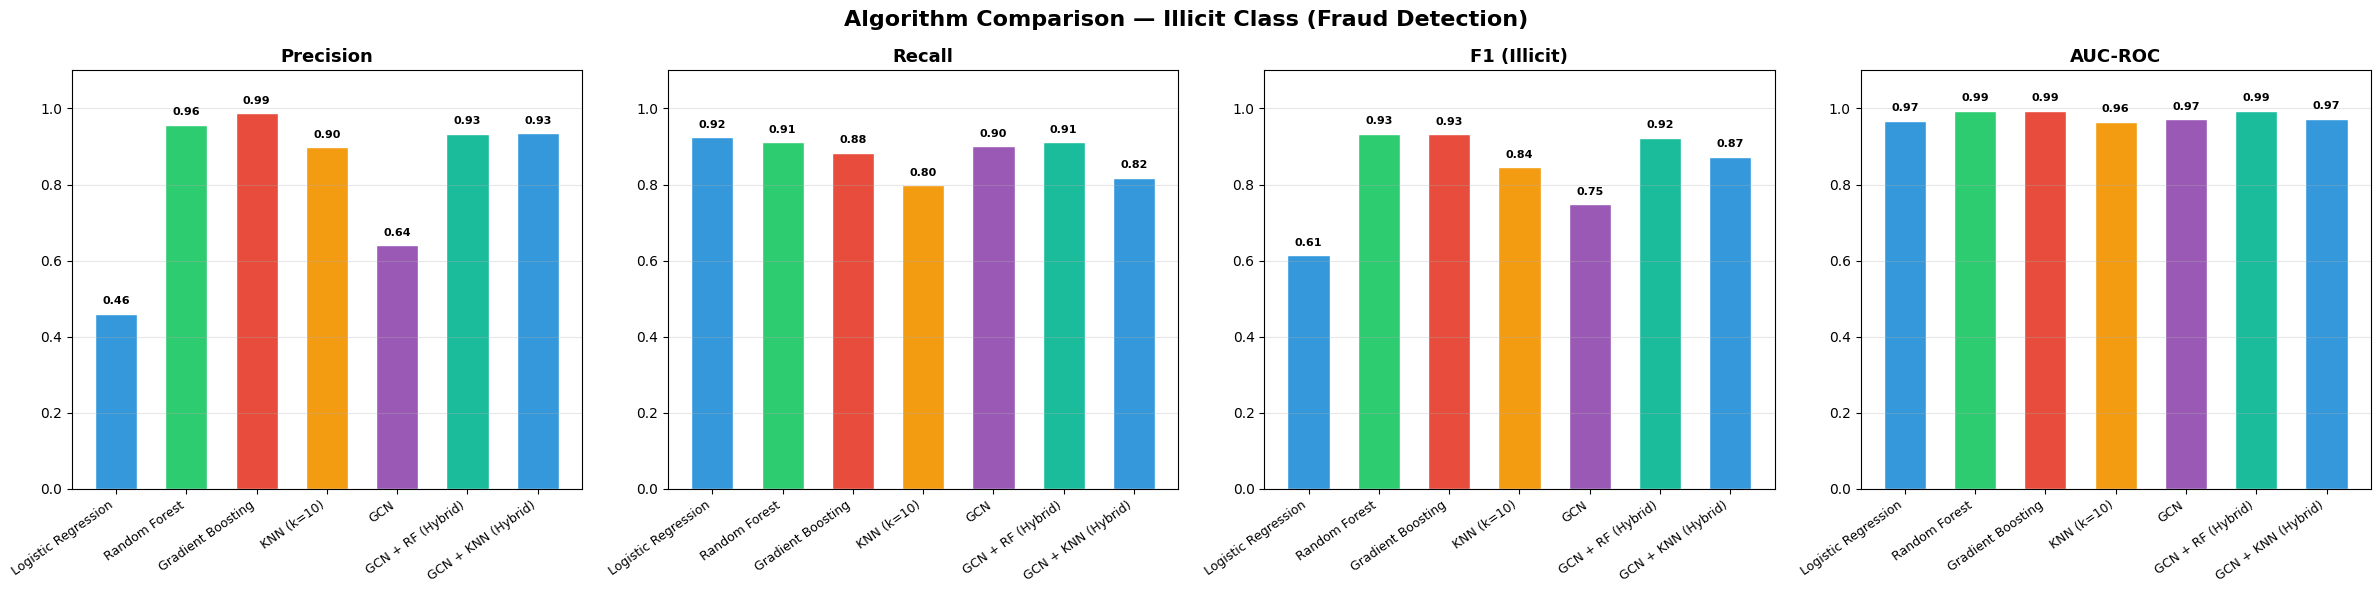

In [42]:
#  Bar chart comparison
model_names   = list(results.keys())
metrics_list  = ['precision', 'recall', 'f1', 'auc']
metric_labels = ['Precision', 'Recall', 'F1 (Illicit)', 'AUC-ROC']
palette       = ['#3498db','#2ecc71','#e74c3c','#f39c12','#9b59b6','#1abc9c']

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
for ax, metric, label in zip(axes, metrics_list, metric_labels):
    vals = [results[m][metric] for m in model_names]
    bars = ax.bar(model_names, vals,
                  color=palette[:len(model_names)],
                  edgecolor='white', width=0.6)
    ax.set_title(label, fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_xticklabels(model_names, rotation=35, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.02,
                f'{val:.2f}', ha='center', va='bottom',
                fontsize=8, fontweight='bold')

fig.suptitle('Algorithm Comparison — Illicit Class (Fraud Detection)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

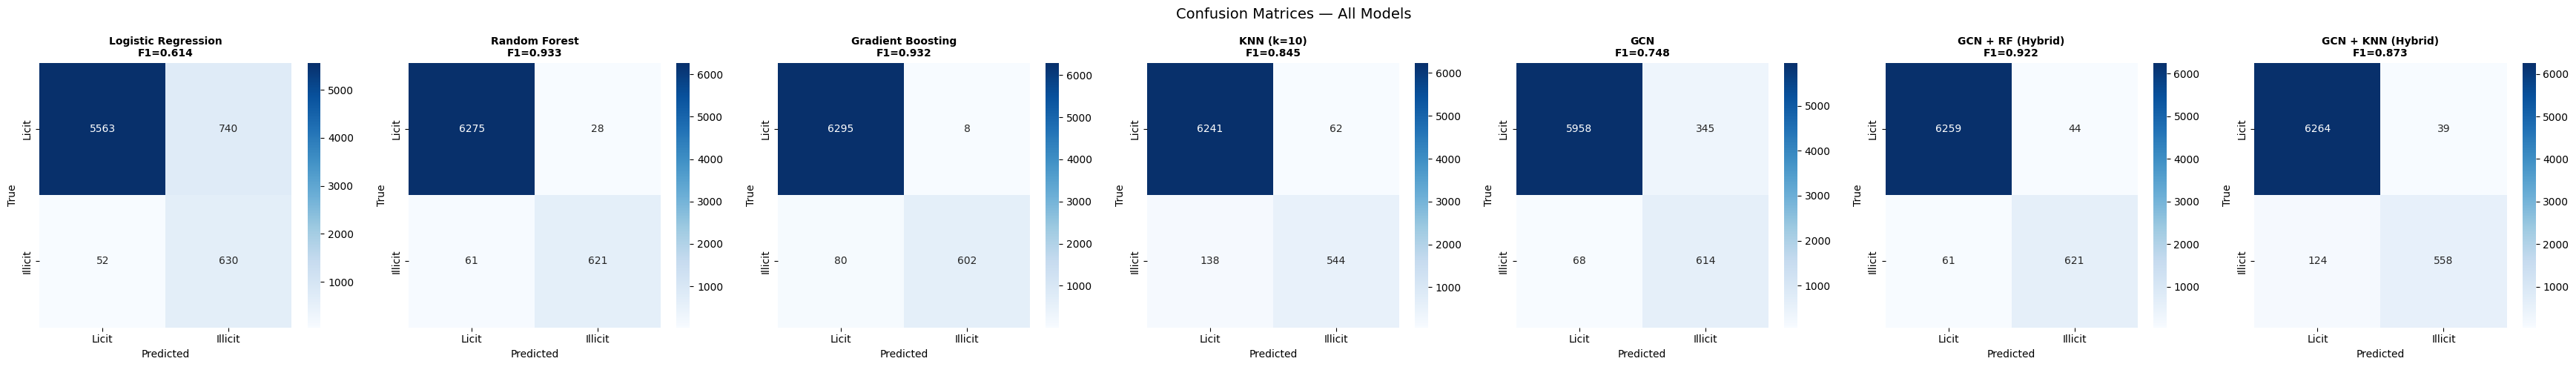

In [43]:
#  Confusion matrices
n = len(results)
fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

for ax, (name, r) in zip(axes, results.items()):
    y_true = true_test if name == 'GCN' else y_test_ml
    cm = confusion_matrix(y_true, r['pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues',
                xticklabels=['Licit','Illicit'],
                yticklabels=['Licit','Illicit'])
    ax.set_title(f'{name}\nF1={r["f1"]:.3f}',
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

fig.suptitle('Confusion Matrices — All Models', fontsize=14)
plt.tight_layout()
plt.show()

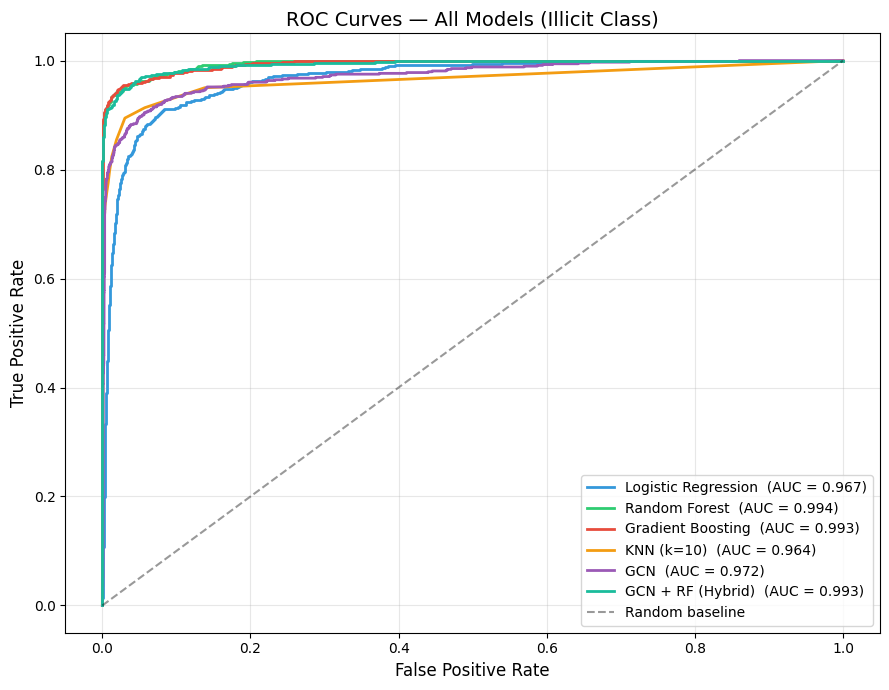

In [44]:
# ROC curves — all models
plt.figure(figsize=(9, 7))

for (name, probs), color in zip(all_probs.items(), palette):
    y_true = true_test if name == 'GCN' else y_test_ml
    fpr, tpr, _ = roc_curve(y_true, probs)
    auc = roc_auc_score(y_true, probs)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name}  (AUC = {auc:.3f})')

plt.plot([0,1],[0,1],'k--', alpha=0.4, label='Random baseline')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves — All Models (Illicit Class)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()